# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [8]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

def mode0(seq):
    '''Ignore motifs, just return average score'''
    return np.mean([score_dict[base] for base in seq])

def mode1(seq):
    '''Return average score, TAT gets +10, GCG gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'TAT' in seq:
        score += 10
    if 'GCG' in seq:
        score -= 10
        
    return score

def mode2(seq):
    '''Return average score, GCG gets +10, TAT gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'GCG' in seq:
        score += 10
    if 'TAT' in seq:
        score -= 10
        
    return score
    

modes = {
    0: mode0,
    1: mode1,
    2: mode2,
}
                  
def score_seqs_multi(seqs, mode_list):
    '''
    Mode 0: ignore motifs
    Mode 1: TAT is high, GCG is low
    Mode 2: GCG is high, TAT is low
    '''
    data = []
    for seq in seqs:
        scores = []
        for mode in mode_list:
            score = modes[mode](seq) # call the mode function
            scores.append(score)
        data.append([seq]+scores)
    
    cols = ['seq'] + [f"mode{m}" for m in mode_list]
        
    df = pd.DataFrame(data, columns=cols)
    return df


In [16]:
multi_df = score_seqs_multi(seqs8,[0,1,2])

In [17]:
multi_df[multi_df['seq']=='AATATAAA']

,seq,mode0,mode1,mode2
3264,AATATAAA,17.75,27.75,7.75


In [18]:
multi_df[multi_df['seq']=='AAGCGATA']

,seq,mode0,mode1,mode2
2444,AAGCGATA,17.0,7.0,27.0


In [19]:
multi_df.head()

,seq,mode0,mode1,mode2
0,AAAAAAAA,20.000,20.000,20.000
1,AAAAAAAC,19.625,19.625,19.625
2,AAAAAAAG,19.250,19.250,19.250
3,AAAAAAAT,18.875,18.875,18.875
4,AAAAAACA,19.625,19.625,19.625


### Define some basic model archs for Linear and CNN

In [25]:
from torch.utils.data import TensorDataset,DataLoader,Dataset
import random
random.seed(7)

In [26]:
class MultiTaskDataset(Dataset):
    def __init__(self,df):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
#         print("Multitask get item***********")
#         print(seq.shape)
#         print(nocu.shape)
#         print(medcu.shape)
        
        return seq, (label0, label1, label2)
        # ??? ^ how is this handled? Does the data loader know what to do with
        # a list of labels...?

In [89]:
class DNA_Linear_Multi(nn.Module):
    def __init__(self,seq_len,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
        # ^^ where does this go and what does it do?
    

In [27]:
def quick_load_and_split_input(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df


def build_dataloaders(df,batch_size=32):
    # train test split
    train_df, test_df = quick_load_and_split_input(df)
    
    # put into dataloader object
    train_ds = MultiTaskDataset(train_df)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    test_ds = MultiTaskDataset(test_df)
    test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
    return train_dl, test_dl,train_df,test_df

In [28]:
train_dl, test_dl,train_df, test_df = build_dataloaders(multi_df)

In [38]:
len(test_dl.dataset.seqs)

13108

In [92]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    #print("in Loss Batch...")
    obj0_target = yb[0].unsqueeze(1).float()
    obj1_target = yb[1].unsqueeze(1).float()
    obj2_target = yb[2].unsqueeze(1).float()
    # need unsqueeze otherwise dimension mismatch? [32] vs [32,1]

    
    #loss = loss_func(model(xb.float()), yb.float())
    # yb is a list of tensors... what should it be?
    # how to adapt loss for multi-task?
    #print("yb[0]:", yb[0])
    
    # try looping through ybs?
    res = model(xb.float()) # get predictions? returns list
    
    loss_obj0 = loss_func(res[0], obj0_target)
    loss_obj1 = loss_func(res[1], obj1_target)
    loss_obj2 = loss_func(res[2], obj2_target)
    
    loss = sum([loss_obj0, loss_obj1, loss_obj2])/3
    
#     print("what is 'loss'?:")
#     print("0:",loss_obj0)
#     print("1:",loss_obj1)
#     print("2:",loss_obj2)
#     print("all:",loss)
#     print("*****")

    if opt is not None:
        opt.zero_grad() # order? should this be first? last?
        loss.backward()
        opt.step()
        

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        print('Epoch:',epoch)
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

# try something

In [93]:
h1 = 100
h2 = 50
seq_len = len(train_df['seq'][0])


In [94]:
seq_len

8

In [95]:
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, multi_lin_model, loss_func, optimizer, train_dl, test_dl)

Epoch: 0
0 11.150406326431307
Epoch: 1
1 8.661822362392822
Epoch: 2
2 8.425481319864021
Epoch: 3
3 8.013875476172467
Epoch: 4
4 7.17358074211514
Epoch: 5
5 6.0831886400054564
Epoch: 6
6 5.293626533400041
Epoch: 7
7 4.8117261514963445
Epoch: 8
8 4.46127036129297
Epoch: 9
9 4.206668212350491


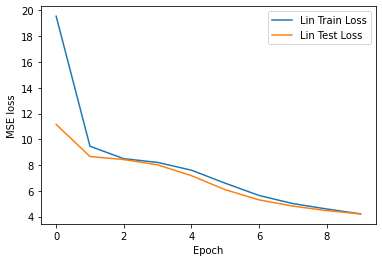

In [96]:
multi_lin_data_label = list(zip([train_losses,val_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(multi_lin_data_label)

In [71]:
def quick_seq_pred_multi(model, seqs):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna))
        pred = [x.item() for x in model(s.float())]
        print(dna, pred)
        

def quick_test8(model):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred_multi(model, seqs)
        print()

In [97]:
quick_test8(multi_lin_model)

AAAAAAAA [20.117324829101562, 16.41199493408203, 23.858354568481445]
CCCCCCCC [17.242460250854492, 20.033510208129883, 14.418214797973633]
GGGGGGGG [14.26758098602295, 8.622066497802734, 19.9227294921875]
TTTTTTTT [11.234105110168457, 15.154129028320312, 7.220312595367432]

AACCAACA [18.82784080505371, 18.340341567993164, 19.31365394592285]
CCGGCGCG [15.455615997314453, 2.5663247108459473, 28.283409118652344]
GGGTAAGG [15.133092880249023, 15.18787670135498, 15.177949905395508]
TTTCGTTT [12.201333045959473, 10.830693244934082, 13.400092124938965]
TGTAATAC [15.302305221557617, 18.713306427001953, 11.801820755004883]

TATAAAAA [17.675722122192383, 22.979949951171875, 12.395286560058594]
CCTATCCC [15.72194766998291, 21.502485275268555, 9.942113876342773]
GTATGGGG [14.15938949584961, 18.68490219116211, 9.774036407470703]
TTTATTTT [12.075251579284668, 18.63201141357422, 5.470189571380615]

AAGCGAAA [17.901073455810547, 12.044368743896484, 23.763526916503906]
CGCGCCCC [16.27444076538086, 9.09

### Try CNN running??

In [98]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3,
                 lin_share_size=10
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_share = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), lin_share_size),
            nn.ReLU(inplace=True),
        ) 
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(lin_share_size,1)
        self.obj1  = nn.Linear(lin_share_size,1)
        self.obj2  = nn.Linear(lin_share_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        
        out = self.conv_share(xb)
        
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
        # ^^ where does this go and what does it do?

In [99]:
seq_len = len(train_df['seq'][0])

multi_cnn_model = DNA_CNN_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnn_model.parameters(), lr=0.001) 

epochs = 10
train_losses_cnn, val_losses_cnn = fit(epochs, multi_cnn_model, loss_func, optimizer, train_dl, test_dl)

Epoch: 0
0 8.708389299687795
Epoch: 1
1 8.067873791946957
Epoch: 2
2 6.643847171438879
Epoch: 3
3 5.0428290200517205
Epoch: 4
4 3.9083826789995646
Epoch: 5
5 2.204411579480723
Epoch: 6
6 1.4776083628942882
Epoch: 7
7 1.2776135894849892
Epoch: 8
8 0.5350732533423174
Epoch: 9
9 0.9420944968483453


In [100]:
quick_test8(multi_cnn_model)

AAAAAAAA [19.8995361328125, 20.38873291015625, 19.44450569152832]
CCCCCCCC [17.131494522094727, 18.92431640625, 15.388649940490723]
GGGGGGGG [14.137066841125488, 14.360057830810547, 13.834417343139648]
TTTTTTTT [11.673979759216309, 14.176370620727539, 9.044564247131348]

AACCAACA [18.680068969726562, 19.078142166137695, 18.333005905151367]
CCGGCGCG [15.273211479187012, 1.7252779006958008, 29.09623908996582]
GGGTAAGG [15.21435546875, 17.120830535888672, 13.26508617401123]
TTTCGTTT [12.201621055603027, 12.692276000976562, 11.6373929977417]
TGTAATAC [15.691433906555176, 16.90957260131836, 14.484530448913574]

TATAAAAA [17.48583221435547, 27.410911560058594, 7.639780521392822]
CCTATCCC [15.916840553283691, 25.704301834106445, 6.240203380584717]
GTATGGGG [13.97425651550293, 23.929780960083008, 3.9733307361602783]
TTTATTTT [12.448463439941406, 22.459379196166992, 2.4056484699249268]

AAGCGAAA [17.96255111694336, 9.785788536071777, 26.175901412963867]
CGCGCCCC [16.247058868408203, 8.014296531

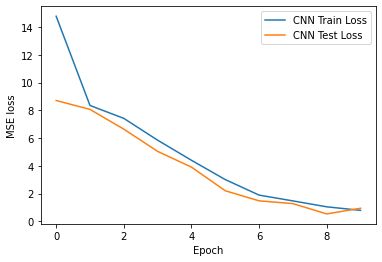

In [101]:
multi_cnn_data_label = list(zip([train_losses_cnn,val_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(multi_cnn_data_label)

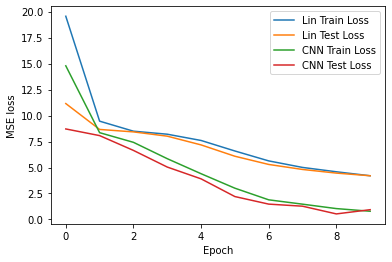

In [102]:
multi_combo_data_label = list(zip([train_losses,val_losses,train_losses_cnn,val_losses_cnn], ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(multi_combo_data_label)

# inspect

### cnn model

In [103]:
multi_cnn_model

DNA_CNN_Multi(
  (conv_share): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=192, out_features=10, bias=True)
    (4): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [104]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(multi_cnn_model)

Total convolutional layers: 1


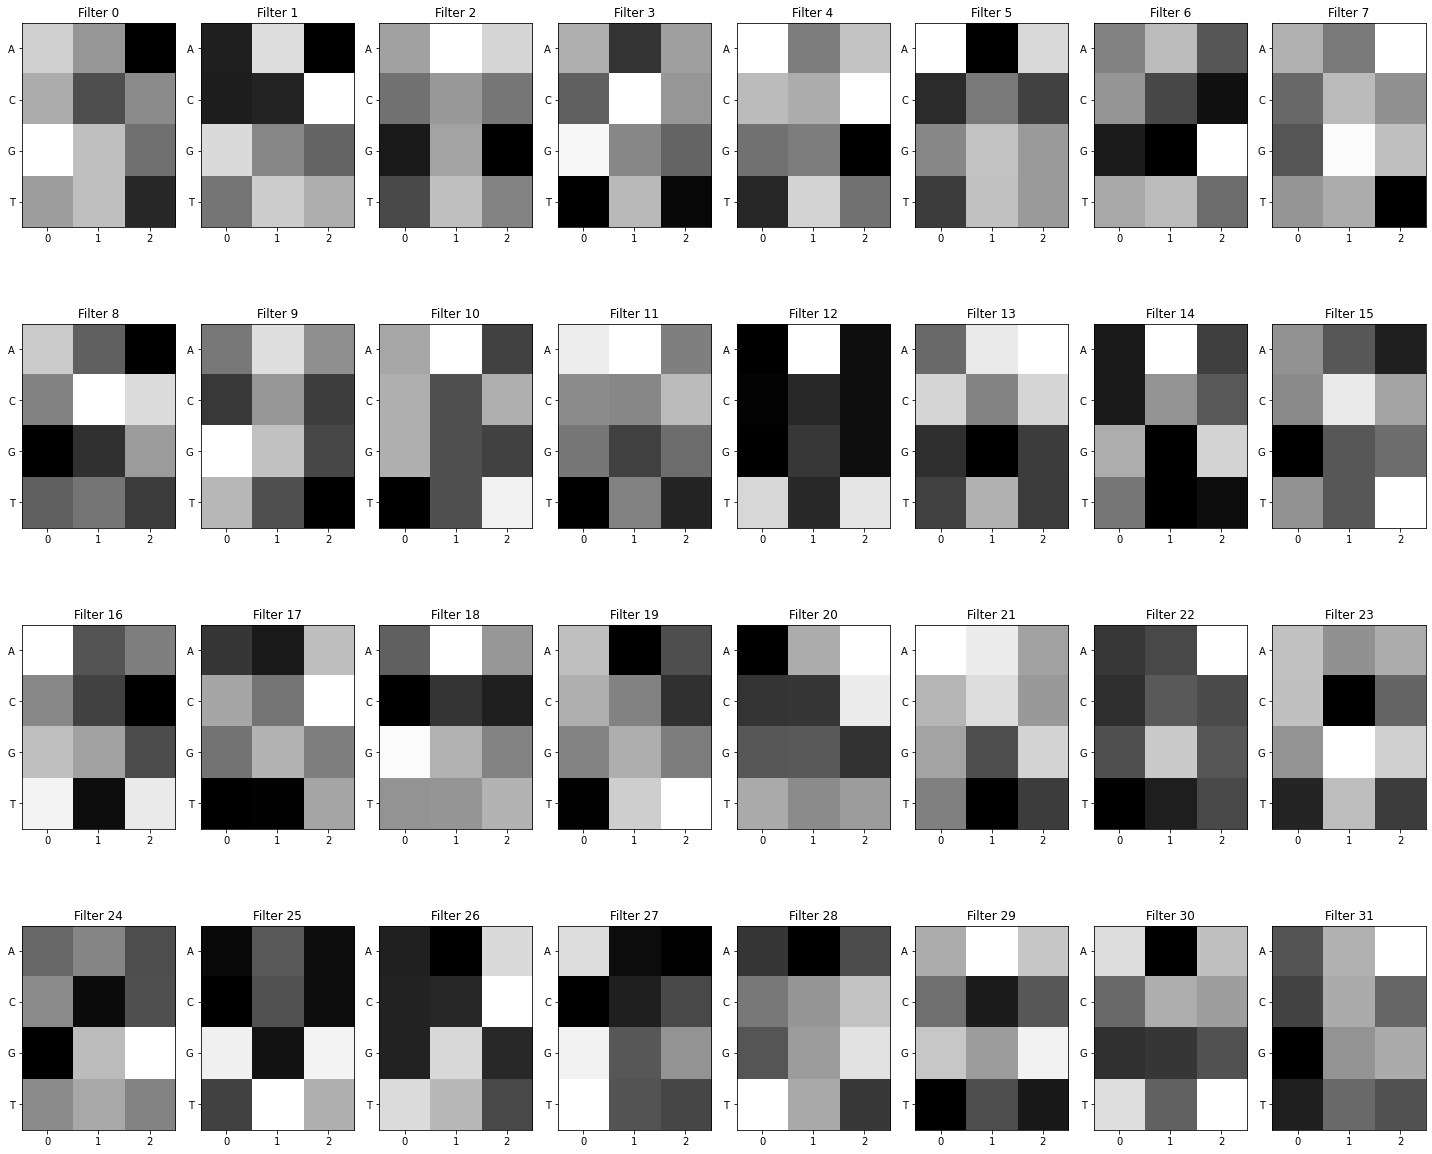

In [105]:
u.view_filters(model_weights)

In [111]:
seqs8_1k = u.downselect_list(seqs8,1000)
filter_activations = u.get_filter_activations(seqs8_1k, conv_layers[0])

Running seq ACCCGGAG
Running seq GGTTGCCA
Running seq CGAGCGTG
Running seq CTAGGCCG
Running seq CCGTCATC
Running seq CGCGGGTT
Running seq CGTGCAGA
Running seq GATCTCAC
Running seq AGCTGATC
Running seq CGTTCCGG
Running seq TCAGGATG
Running seq GGTCATCT
Running seq AGTCAGAT
Running seq TACCGACG
Running seq AGTGGATG
Running seq AGGTAATC
Running seq TATCATGG
Running seq AAATAACT
Running seq AAGGGGGG
Running seq AGTGTATG
Running seq CCATTTAC
Running seq CTTAAAGT
Running seq TGTGCCCT
Running seq CCAGCCTC
Running seq GCAGCATT
Running seq CTATTTAG
Running seq GCGGCTGA
Running seq TTTCATGA
Running seq CAGTCCGT
Running seq CCGCTAGC
Running seq ACCCTACT
Running seq AAGGCCCA
Running seq GTGTCGGG
Running seq AATCATTA
Running seq ATTTGGGT
Running seq AGCCGTTA
Running seq GACCGAGA
Running seq CAAACGCA
Running seq GGTAAGGA
Running seq ATGTGCTA
Running seq TATTATGT
Running seq GAAGATGG
Running seq TTGAAGTC
Running seq GTAAAGCT
Running seq ATACTGGG
Running seq AGTGTAAA
Running seq CCTGTGCC
Running seq A

Running seq TGTGGTCA
Running seq ATCACCCC
Running seq CATTGGTC
Running seq TGGTTTTG
Running seq ACGATGCA
Running seq ACTCATGG
Running seq CCCGTACA
Running seq TAACGTCT
Running seq CGATTGAT
Running seq TCGTACTA
Running seq ATATCCAG
Running seq GCGTCCAC
Running seq GGATGCCA
Running seq ATGTACAA
Running seq CAGGTCGG
Running seq TGGTCACC
Running seq TTTACGTT
Running seq AGCTATGC
Running seq TATTCGTT
Running seq GTGCCCTT
Running seq TCGGGTGT
Running seq CGGTCCAT
Running seq AGTCCGGG
Running seq GGTAGCCC
Running seq ACCACGTA
Running seq AAAGTCTC
Running seq GTAACCCA
Running seq TTTGTGCG
Running seq ATGCTATT
Running seq GTCTCCAC
Running seq GGCGCATC
Running seq TCACGGGA
Running seq ACATATCC
Running seq CACGGGGT
Running seq TCTTGGCG
Running seq ACTATAAA
Running seq GTGGCACG
Running seq GTAATTAA
Running seq CCTGTCAG
Running seq CCCATTTA
Running seq CACTCGTC
Running seq CGAGCCCA
Running seq CTAGGCGA
Running seq CGATACCC
Running seq TCAAACCA
Running seq GGCAGGTC
Running seq AAATCGGG
Running seq A

Running seq TCGCGCCT
Running seq ACTTTACT
Running seq CCCGGGGT
Running seq AGAGTGTC
Running seq TAACTGGA
Running seq GAGGTGCT
Running seq TACGAAAT
Running seq CTGTGTTG
Running seq TCGAAGTT
Running seq AAACTACG
Running seq TGAGCCAG
Running seq TCGTCTCA
Running seq CATTGCTA
Running seq CCAATATA
Running seq CTACGTCA
Running seq TTTCCGTG
Running seq GGAGGAAA
Running seq GGGACGTT
Running seq TATATCCT
Running seq AATTAGCT
Running seq GTGGATAA
Running seq CACACACT
Running seq AATGGATG
Running seq GACGTATT
Running seq CGCTTGGC
Running seq ATCGAGCT
Running seq GCTTAAGG
Running seq GGCTACTG
Running seq ACCTATCA
Running seq CTATAGGG
Running seq GTTCTCAT
Running seq CATACTAG
Running seq CCCCTGTA
Running seq GCCTCCAT
Running seq CGGACCCA
Running seq GTACAAGA
Running seq CCGTTCCG
Running seq CAGTGTAG
Running seq GCCTGTCG
Running seq TCCAAGAA
Running seq GCTCACAA
Running seq TCAACCTT
Running seq GCAGTTGA
Running seq TTTTACTC
Running seq GTTGGAAA
Running seq GACACTTC
Running seq CGTGAAAC
Running seq G

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


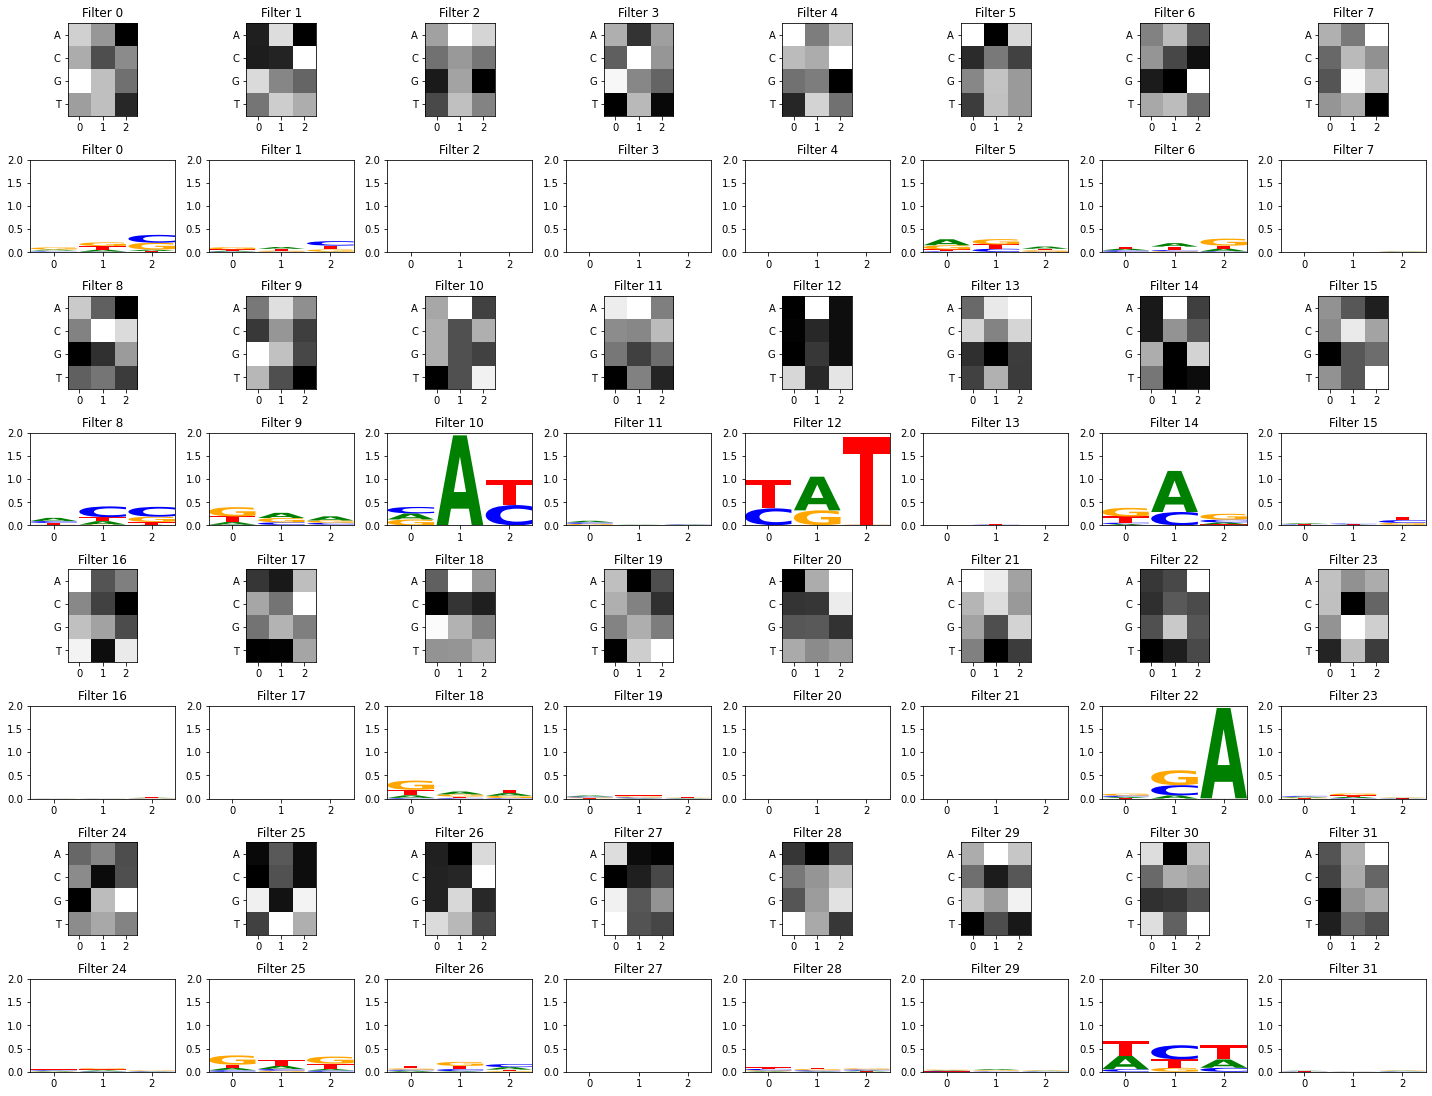

In [112]:
u.view_filters_and_logos(model_weights,filter_activations)